# Chapter 3

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [4]:
'''
DSC 530
Week 4

Programming Assignment Week 4
Author: Joshua Greenert
Date: 6/29/2022

Use the NSFG respondent variable NUMKDHH to construct the actual distribution
for the number of children under 18 in the household.  Compute the biased distriibution
we would see if we surveyed the children and asked them how many children under 18
are in their household.  Plot the actual and biased distributions and compute
their means.
'''

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [5]:
import numpy as np

Again, I'll load the NSFG pregnancy file and select live births:

In [6]:
import nsfg
import first
import thinkstats2
import thinkplot

In [16]:
preg = nsfg.ReadFemPreg()
live = preg[preg.outcome == 1]
print(live)

       caseid  pregordr  howpreg_n  howpreg_p  moscurrp  nowprgdk  pregend1  \
0           1         1        NaN        NaN       NaN       NaN       6.0   
1           1         2        NaN        NaN       NaN       NaN       6.0   
2           2         1        NaN        NaN       NaN       NaN       5.0   
3           2         2        NaN        NaN       NaN       NaN       6.0   
4           2         3        NaN        NaN       NaN       NaN       6.0   
...       ...       ...        ...        ...       ...       ...       ...   
13581   12568         2        NaN        NaN       NaN       NaN       5.0   
13584   12569         2        NaN        NaN       NaN       NaN       6.0   
13588   12571         1        NaN        NaN       NaN       NaN       6.0   
13591   12571         4        NaN        NaN       NaN       NaN       6.0   
13592   12571         5        NaN        NaN       NaN       NaN       6.0   

       pregend2  nbrnaliv  multbrth  ...  laborfor_

Here's the histogram of birth weights:

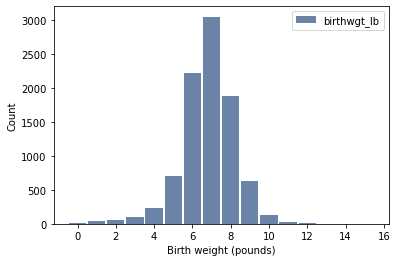

In [5]:
hist = thinkstats2.Hist(live.birthwgt_lb, label="birthwgt_lb")
thinkplot.Hist(hist)
thinkplot.Config(xlabel="Birth weight (pounds)", ylabel="Count")

To normalize the disrtibution, we could divide through by the total count:

In [38]:
n = hist.Total()
pmf = hist.Copy()
for x, freq in hist.Items():
    pmf[x] = freq / n

The result is a Probability Mass Function (PMF).

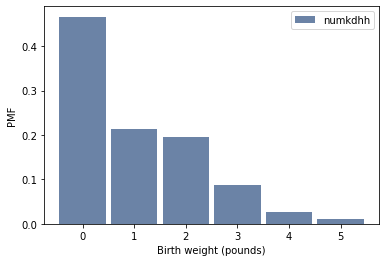

In [39]:
thinkplot.Hist(pmf)
thinkplot.Config(xlabel="Birth weight (pounds)", ylabel="PMF")

More directly, we can create a Pmf object.

In [40]:
pmf = thinkstats2.Pmf([1, 2, 2, 3, 5])
pmf

Pmf({1: 0.2, 2: 0.4, 3: 0.2, 5: 0.2})

`Pmf` provides `Prob`, which looks up a value and returns its probability:

In [41]:
pmf.Prob(2)

0.4

The bracket operator does the same thing.

In [42]:
pmf[2]

0.4

The `Incr` method adds to the probability associated with a given values.

In [43]:
pmf.Incr(2, 0.2)
pmf[2]

0.6000000000000001

The `Mult` method multiplies the probability associated with a value.

In [44]:
pmf.Mult(2, 0.5)
pmf[2]

0.30000000000000004

`Total` returns the total probability (which is no longer 1, because we changed one of the probabilities).

In [45]:
pmf.Total()

0.8999999999999999

`Normalize` divides through by the total probability, making it 1 again.

In [14]:
pmf.Normalize()
pmf.Total()

1.0

Here's the PMF of pregnancy length for live births.

In [46]:
pmf = thinkstats2.Pmf(live.prglngth, label="prglngth")


Here's what it looks like plotted with `Hist`, which makes a bar graph.

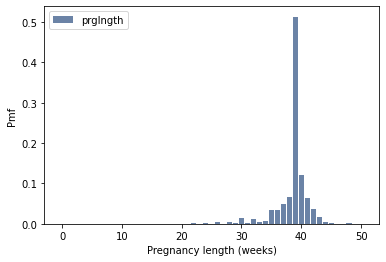

In [47]:
thinkplot.Hist(pmf)
thinkplot.Config(xlabel="Pregnancy length (weeks)", ylabel="Pmf")

Here's what it looks like plotted with `Pmf`, which makes a step function.

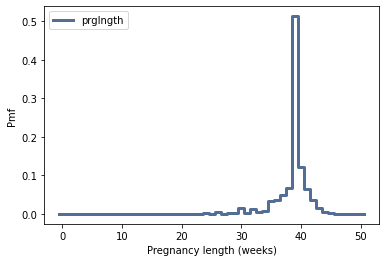

In [48]:
thinkplot.Pmf(pmf)
thinkplot.Config(xlabel="Pregnancy length (weeks)", ylabel="Pmf")

We can use `MakeFrames` to return DataFrames for all live births, first babies, and others.

In [49]:
live, firsts, others = first.MakeFrames()

Here are the distributions of pregnancy length.

In [50]:
first_pmf = thinkstats2.Pmf(firsts.prglngth, label="firsts")
other_pmf = thinkstats2.Pmf(others.prglngth, label="others")

And here's the code that replicates one of the figures in the chapter.

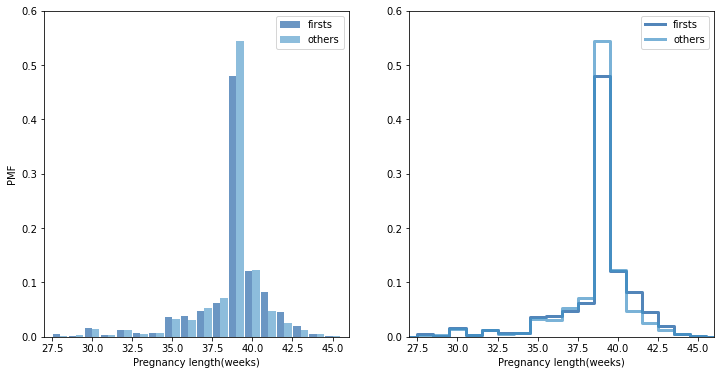

In [51]:
width = 0.45
axis = [27, 46, 0, 0.6]
thinkplot.PrePlot(2, cols=2)
thinkplot.Hist(first_pmf, align="right", width=width)
thinkplot.Hist(other_pmf, align="left", width=width)
thinkplot.Config(xlabel="Pregnancy length(weeks)", ylabel="PMF", axis=axis)

thinkplot.PrePlot(2)
thinkplot.SubPlot(2)
thinkplot.Pmfs([first_pmf, other_pmf])
thinkplot.Config(xlabel="Pregnancy length(weeks)", axis=axis)

Here's the code that generates a plot of the difference in probability (in percentage points) between first babies and others, for each week of pregnancy (showing only pregnancies considered "full term"). 

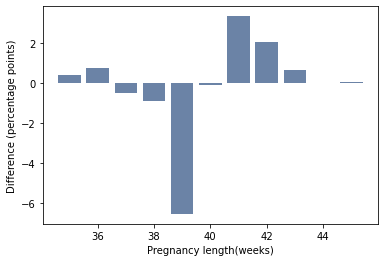

In [52]:
weeks = range(35, 46)
diffs = []
for week in weeks:
    p1 = first_pmf.Prob(week)
    p2 = other_pmf.Prob(week)
    diff = 100 * (p1 - p2)
    diffs.append(diff)

thinkplot.Bar(weeks, diffs)
thinkplot.Config(xlabel='Pregnancy length(weeks)', ylabel='Difference (percentage points)')


### Biasing and unbiasing PMFs

Here's the example in the book showing operations we can perform with `Pmf` objects.

Suppose we have the following distribution of class sizes.

In [53]:
d = {7: 8, 12: 8, 17: 14, 22: 4, 27: 6, 32: 12, 37: 8, 42: 3, 47: 2}

pmf = thinkstats2.Pmf(d, label="actual")
pmf

Pmf({7: 0.12307692307692308, 12: 0.12307692307692308, 17: 0.2153846153846154, 22: 0.06153846153846154, 27: 0.09230769230769231, 32: 0.18461538461538463, 37: 0.12307692307692308, 42: 0.046153846153846156, 47: 0.03076923076923077}, 'actual')

This function computes the biased PMF we would get if we surveyed students and asked about the size of the classes they are in.

In [54]:
def BiasPmf(pmf, label):
    new_pmf = pmf.Copy(label=label)

    for x, p in pmf.Items():
        new_pmf.Mult(x, x)

    new_pmf.Normalize()
    return new_pmf

The following graph shows the difference between the actual and observed distributions.

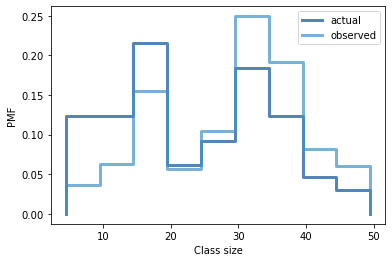

In [55]:
biased_pmf = BiasPmf(pmf, label="observed")
thinkplot.PrePlot(2)
thinkplot.Pmfs([pmf, biased_pmf])
thinkplot.Config(xlabel="Class size", ylabel="PMF")

The observed mean is substantially higher than the actual.

In [56]:
print("Actual mean", pmf.Mean())
print("Observed mean", biased_pmf.Mean())

Actual mean 23.692307692307693
Observed mean 29.123376623376625


If we were only able to collect the biased sample, we could "unbias" it by applying the inverse operation.

In [57]:
def UnbiasPmf(pmf, label=None):
    new_pmf = pmf.Copy(label=label)

    for x, p in pmf.Items():
        new_pmf[x] *= 1 / x

    new_pmf.Normalize()
    return new_pmf

We can unbias the biased PMF:

In [58]:
unbiased = UnbiasPmf(biased_pmf, label="unbiased")
print("Unbiased mean", unbiased.Mean())

Unbiased mean 23.69230769230769


And plot the two distributions to confirm they are the same.

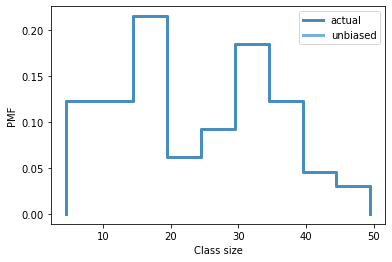

In [59]:
thinkplot.PrePlot(2)
thinkplot.Pmfs([pmf, unbiased])
thinkplot.Config(xlabel="Class size", ylabel="PMF")

### Pandas indexing

Here's an example of a small DataFrame.

In [60]:
import numpy as np
import pandas

array = np.random.randn(4, 2)
df = pandas.DataFrame(array)
df

,0,1
0,1.608374,-1.212834
1,-1.378854,-0.043093
2,-2.156457,0.049254
3,-0.002490,-0.435393


We can specify column names when we create the DataFrame:

In [61]:
columns = ["A", "B"]
df = pandas.DataFrame(array, columns=columns)
df

,A,B
0,1.608374,-1.212834
1,-1.378854,-0.043093
2,-2.156457,0.049254
3,-0.002490,-0.435393


We can also specify an index that contains labels for the rows.

In [43]:
index = ["a", "b", "c", "d"]
df = pandas.DataFrame(array, columns=columns, index=index)
df

,A,B
a,0.377989,-1.285502
b,-0.369686,0.901096
c,0.668701,-0.890922
d,-1.067402,1.356216


Normal indexing selects columns.

In [44]:
df["A"]

a    0.377989
b   -0.369686
c    0.668701
d   -1.067402
Name: A, dtype: float64

We can use the `loc` attribute to select rows.

In [45]:
df.loc["a"]

A    0.377989
B   -1.285502
Name: a, dtype: float64

If you don't want to use the row labels and prefer to access the rows using integer indices, you can use the `iloc` attribute:

In [46]:
df.iloc[0]

A    0.377989
B   -1.285502
Name: a, dtype: float64

`loc` can also take a list of labels.

In [47]:
indices = ["a", "c"]
df.loc[indices]

,A,B
a,0.377989,-1.285502
c,0.668701,-0.890922


If you provide a slice of labels, `DataFrame` uses it to select rows.

In [48]:
df["a":"c"]

,A,B
a,0.377989,-1.285502
b,-0.369686,0.901096
c,0.668701,-0.890922


If you provide a slice of integers, `DataFrame` selects rows by integer index.

In [49]:
df[0:2]

,A,B
a,0.377989,-1.285502
b,-0.369686,0.901096


But notice that one method includes the last elements of the slice and one does not.

In general, I recommend giving labels to the rows and names to the columns, and using them consistently.

## Exercises

**Exercise:** In Chapter 3 we computed the mean of a sample by adding up
the elements and dividing by n.  If you are given a PMF, you can
still compute the mean, but the process is slightly different:
%
$$ \xbar = \sum_i p_i~x_i $$
%
where the $x_i$ are the unique values in the PMF and $p_i=PMF(x_i)$.
Similarly, you can compute variance like this:
%
$$ S^2 = \sum_i p_i~(x_i - \xbar)^2 $$
% 
Write functions called `PmfMean` and `PmfVar` that take a
Pmf object and compute the mean and variance.  To test these methods,
check that they are consistent with the methods `Mean` and `Var`
provided by `Pmf`.

In [50]:
def PmfMean(pmf):
    """Computes the mean of a PMF.
    Returns:
        float mean
    """
    return sum(p * x for x, p in pmf.Items())

In [51]:
def PmfVar(pmf, mu=None):
    """Computes the variance of a PMF.
    mu: the point around which the variance is computed;
            if omitted, computes the mean
    returns: float variance
    """
    if mu is None:
        mu = PmfMean(pmf)

    return sum(p * (x - mu) ** 2 for x, p in pmf.Items())

**Exercise:** Something like the class size paradox appears if you survey children and ask how many children are in their family. Families with many children are more likely to appear in your sample, and families with no children have no chance to be in the sample.

Use the NSFG respondent variable `numkdhh` to construct the actual distribution for the number of children under 18 in the respondents' households.

Now compute the biased distribution we would see if we surveyed the children and asked them how many children under 18 (including themselves) are in their household.

Plot the actual and biased distributions, and compute their means.

In [2]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz")

NameError: name 'download' is not defined

In [25]:
# Read the data from the 2002FemResp dct file.
resp = nsfg.ReadFemResp()

In [1]:
# Create a PMF using the thinkstats2 class
pmf = thinkstats2.Pmf(resp.numkdhh, label="NumOfChildren")

# Create the chart for the pmf to test.
thinkplot.Pmf(pmf)
thinkplot.Config(xlabel="Children", ylabel="Data")

NameError: name 'thinkstats2' is not defined

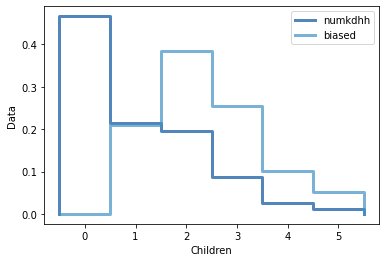

In [72]:
# Create a biased pmf based on the first pmf object.
biased = BiasPmf(pmf, label="biased")

# Create a plot of the biased pmf to compare with the original.
thinkplot.PrePlot(2)
thinkplot.Pmfs([pmf, biased])
thinkplot.Config(xlabel="Children", ylabel="Data")

In [75]:
# Display the biased mean.
biased.Mean()

2.403679100664282

In [76]:
# Display the pmf mean.
pmf.Mean()

1.024205155043831